На етот раз сначала сделаю полностью задачу регрессии, а потом возьмусь за классификацию

# Линейная регрессия
## Создание бейзлайна линейной регрессии и оценка качества

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [2]:
# Загружаем и обрабатываем данные
df = pd.read_csv("diamonds.csv")

X = df.drop(columns=['price'])
y = df['price']

# Определяем числовые и категориальные признаки
numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_features = ['cut', 'color', 'clarity']

# Трансформер признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [3]:
# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

results_linreg = []

# Применяем препроцессор
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Обучение линейной регрессии
lin_reg = LinearRegression()
lin_reg.fit(X_train_proc, y_train)


y_pred = lin_reg.predict(X_test_proc)

# Метрики
print("="*50)
print("Бейзлайн Linear Regression")
print("="*50)
print(f"R2:   {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")

results_linreg.append({
    "Гипотеза": "Базовая",
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred)
})

Бейзлайн Linear Regression
R2:   0.9202
RMSE: 1115.6906
MAE:  734.2415


Как мы видим результаты значительно хуже, чем были у обычного KNN. Линейная регрессия хуже справляется с данной задачей т.к. распределение цен на брилианты не равномерное.

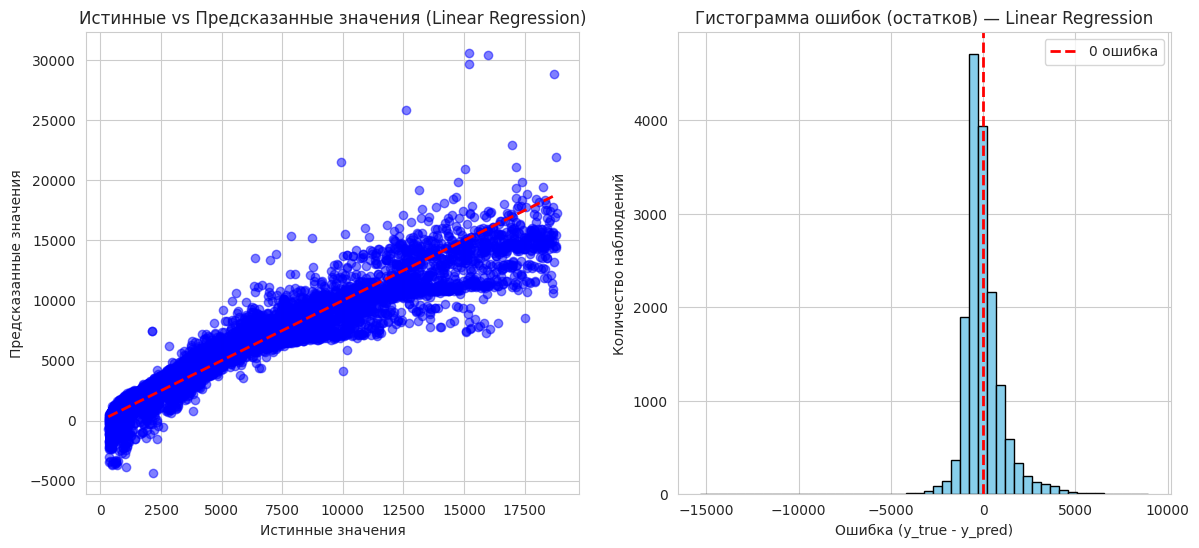

In [4]:
# Остатки
residuals = y_test - y_pred

# Истинные vs Предсказанные значения
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные значения (Linear Regression)')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Гистограмма ошибок (остатков) — Linear Regression")
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='0 ошибка')
plt.legend()
plt.show()

По графику истинных и предсказанных значений можно заметить, что предсказанные случаи распределены не равномерно вокруг линии. Предсказанные случаи распределены так, будто наша линия должна загибаться, что не является верным. Попробуем улучшить ситуацию в улучшенном бейзлайне

## Выдвигаем гипотезы

### Гипотеза 1 - улучшение препроцессинга признаков
Стандартизация числовых признаков и корректная кодировка категориальных (OneHotEncoder или Target Encoding) уменьшит разброс данных и повысит точность линейной регрессии.

### Гипотеза 2 - логарифмирование целевой переменной
Так как распределение цен сильно скошено, применение логарифмирования к price перед обучением сделает модель более стабильной, а метрики RMSE и MAE — информативными.

### Гипотеза 3 - подбор гиперпараметров регуляризации
Использование Ridge или Lasso Regression с подбором коэффициента регуляризации через кросс-валидацию снизит переобучение и повысит точность предсказаний.

### Гипотеза 4 - взвешивание объектов / редких ценовых диапазонов
Назначение более высоких весов редким или экстремальным объектам (например, дорогим бриллиантам) позволит модели учитывать их важность и уменьшить смещение в сторону массового сегмента.

### Гипотеза 5 - разделение данных на сегменты
Разделение данных по диапазонам цен и обучение отдельной модели для каждого сегмента может повысить точность предсказаний внутри сегмента.

In [5]:
# Гипотеза 1
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_proc, y_train)
y_pred = lin_reg.predict(X_test_proc)

results_linreg.append({
    "Гипотеза": "Гипотеза 1",
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred)
})


In [6]:
# Гипотеза 2
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_proc, y_train_log)
y_pred_log = lin_reg.predict(X_test_proc)
y_pred = np.expm1(y_pred_log) 

results_linreg.append({
    "Гипотеза": "Гипотеза 2",
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred)
})


In [7]:
# Гипотеза 3 
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_ridge.fit(X_train_proc, y_train)
y_pred = grid_ridge.predict(X_test_proc)

results_linreg.append({
    "Гипотеза": "Гипотеза 3",
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred)
})

best_alpha = grid_ridge.best_params_['alpha']
print(f"Гипотеза 3: Лучший коэффициент регуляризации alpha = {best_alpha}")


Гипотеза 3: Лучший коэффициент регуляризации alpha = 10


In [8]:
# Гипотеза 4
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
        10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, np.inf]
counts, _ = np.histogram(y_train, bins=bins)

# Сглаживаем веса через логарифм
weights_per_bin = np.log1p(np.max(counts) / (counts + 1e-5))
bin_indices = np.digitize(y_train, bins) - 1
weights = weights_per_bin[bin_indices]

lin_reg = LinearRegression()
lin_reg.fit(X_train_proc, y_train, sample_weight=weights)
y_pred_hyp4 = lin_reg.predict(X_test_proc)  # сохраняем предсказания для графиков

# Сохраняем метрики
results_linreg.append({
    "Гипотеза": "Гипотеза 4",
    "R2": r2_score(y_test, y_pred_hyp4),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_hyp4)),
    "MAE": mean_absolute_error(y_test, y_pred_hyp4)
})

# Сохраняем данные для графиков
y_test_hyp4 = y_test.copy()
residuals_hyp4 = y_test_hyp4 - y_pred_hyp4


In [9]:
# Гипотеза 5
segments = [(0, 5000), (5000, np.inf)]
y_pred_hyp5 = np.zeros(len(y_test))

for seg_min, seg_max in segments:
    mask_train = (y_train >= seg_min) & (y_train < seg_max)
    mask_test = (y_test >= seg_min) & (y_test < seg_max)
    
    if mask_train.sum() == 0 or mask_test.sum() == 0:
        continue
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_proc[mask_train], y_train[mask_train])
    y_pred_hyp5[mask_test] = lin_reg.predict(X_test_proc[mask_test])

# Метрики
results_linreg.append({
    "Гипотеза": "Гипотеза 5",
    "R2": r2_score(y_test, y_pred_hyp5),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_hyp5)),
    "MAE": mean_absolute_error(y_test, y_pred_hyp5)
})

# Сохраняем данные для графиков
y_test_hyp5 = y_test.copy()
residuals_hyp5 = y_test_hyp5 - y_pred_hyp5


Анализируем и сравниваем полученные результаты

In [10]:
df_results = pd.DataFrame(results_linreg)

print("="*70)
print("Сравнение всех моделей Linear Regression")
print("="*70)
display(df_results.sort_values("R2", ascending=False))

Сравнение всех моделей Linear Regression


,Гипотеза,R2,RMSE,MAE
5,Гипотеза 5,0.964188,747.347049,409.979491
2,Гипотеза 2,0.932176,1028.484400,468.102047
3,Гипотеза 3,0.920209,1115.535924,734.066016
0,Базовая,0.920187,1115.690565,734.241516
1,Гипотеза 1,0.920187,1115.690565,734.241516
4,Гипотеза 4,0.903787,1224.965394,900.661667


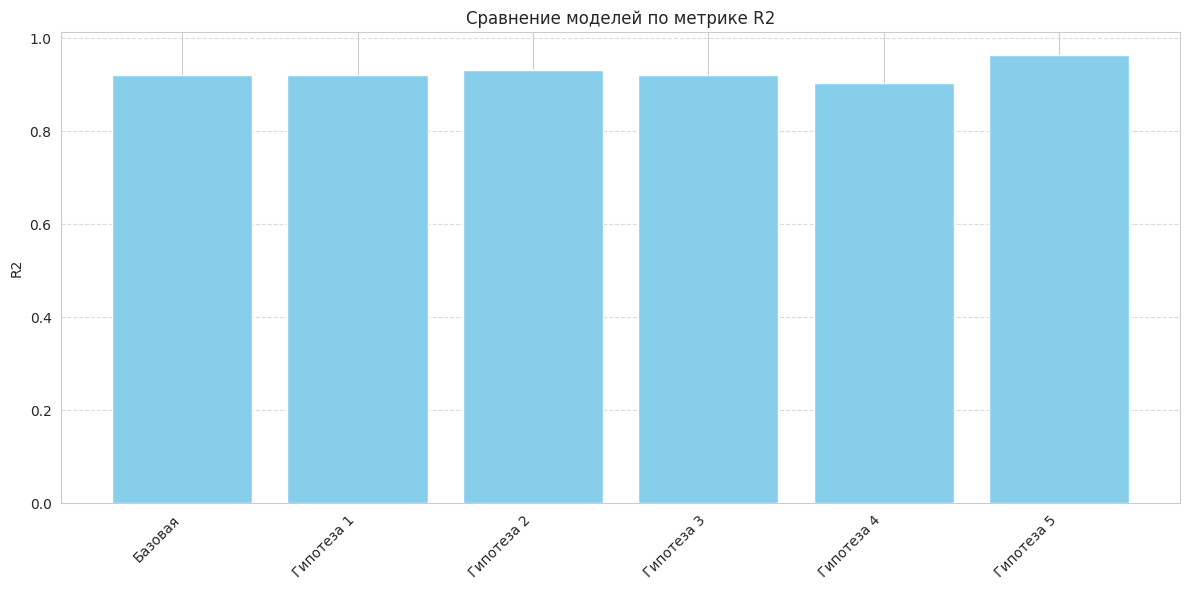

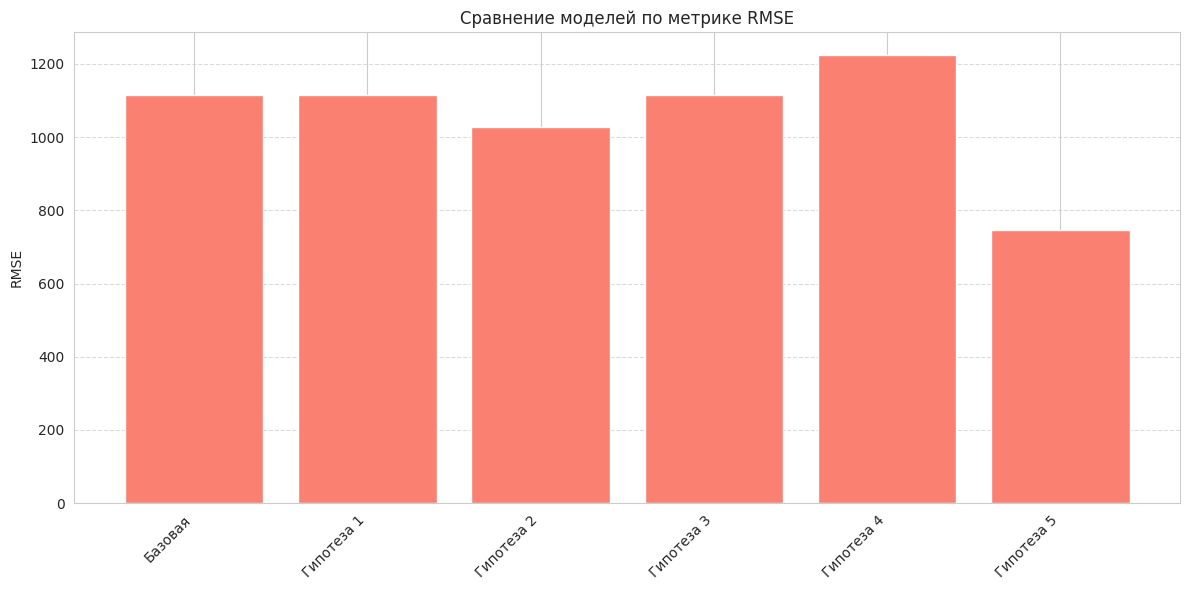

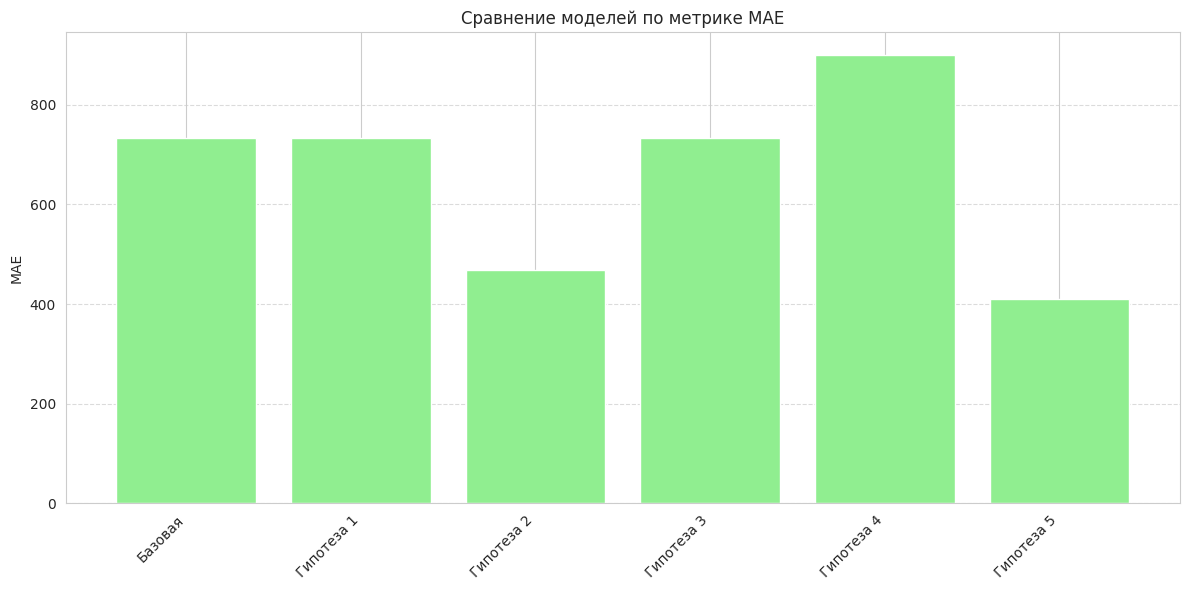

In [11]:
# Графики по метрикам

metrics = ["R2", "RMSE", "MAE"]
colors = ["skyblue", "salmon", "lightgreen"]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(12, 6))
    plt.bar(df_results["Гипотеза"], df_results[metric], color=colors[i])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric)
    plt.title(f"Сравнение моделей по метрике {metric}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Как видно из результатов, ничего кроме гипотез 2 и 5 не имеет смысла. Ну еще гипотеза 3 дает немного прибавки, но идеальный подбор гиперпараметров дает не так много. Гипотезы же 1 и 4 и вовсе проигрывают обычной линейной регрессии. Теперь попробуем совместить гипотезы 2 и 5 и получить наилучший результат

## Улучшенный бейзлайн

Пробуем совместить гипотезы 2 и 5. Будем сегментировать по квантилям. Совмещение гипотез "влоб" давало неадекватные ответы, так что пришлось думать.

In [12]:

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


quantiles = y_train_log.quantile([0.5]).values  
segments = [(y_train_log.min(), quantiles[0]), (quantiles[0], y_train_log.max())]

predictions = np.zeros(len(y_test))

for seg_min, seg_max in segments:

    mask_train = (y_train_log >= seg_min) & (y_train_log < seg_max)
    mask_test = (y_test_log >= seg_min) & (y_test_log < seg_max)
    
    if mask_train.sum() == 0 or mask_test.sum() == 0:
        continue

    lin_reg = LinearRegression()
    lin_reg.fit(X_train_proc[mask_train], y_train_log[mask_train])
    
    y_pred_log = lin_reg.predict(X_test_proc[mask_test])
    predictions[mask_test] = np.expm1(y_pred_log)  

# Метрики
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print("="*50)
print("Гипотеза 2 + 5")
print("="*50)
print(f"R2:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# Сохраняем результаты
results_linreg.append({
    "Гипотеза": "Гипотеза 2 + 5",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})

Гипотеза 2 + 5
R2:   0.9086
RMSE: 1194.0317
MAE:  468.8418


In [13]:
df_results = pd.DataFrame(results_linreg)

print("="*70)
print("Сравнение всех моделей Linear Regression")
print("="*70)
display(df_results.sort_values("R2", ascending=False))

Сравнение всех моделей Linear Regression


,Гипотеза,R2,RMSE,MAE
5,Гипотеза 5,0.964188,747.347049,409.979491
2,Гипотеза 2,0.932176,1028.484400,468.102047
3,Гипотеза 3,0.920209,1115.535924,734.066016
0,Базовая,0.920187,1115.690565,734.241516
1,Гипотеза 1,0.920187,1115.690565,734.241516
6,Гипотеза 2 + 5,0.908585,1194.031736,468.841783
4,Гипотеза 4,0.903787,1224.965394,900.661667


Как мы видим, совмещение двух гипотез дало результат хуже каждой из двух гипотез по отдельности. Очевидно, что ето связано с тем, что обе данные гипотезы работают с ценой в совершенно разных направлениях и из-за етого их совмещение весьма затруднительно. Однако показатели MAE, несмотря на то что гипотеза получилось даже чуть похуже базовой по R2, остаются на уровне гипотезы 2.

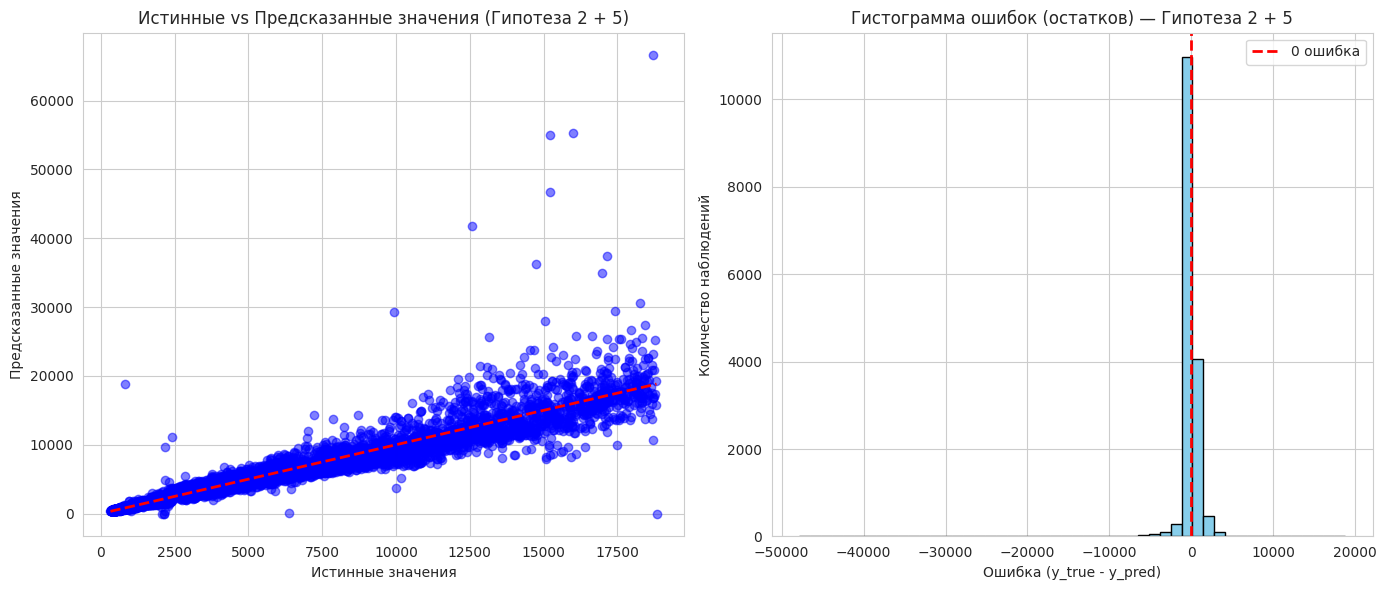

In [14]:
# Остатки
residuals = y_test - predictions

# Истинные vs Предсказанные значения
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные значения (Гипотеза 2 + 5)')
plt.grid(True)

# Гистограмма ошибок (остатков)
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Гистограмма ошибок (остатков) — Гипотеза 2 + 5")
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='0 ошибка')
plt.legend()

plt.tight_layout()
plt.show()


Как можно заметить, график в целом выглядит иначе чем оригинальный: видно, что точки собраны вокруг линии и что они не "закручиваются". Хотя чем выше цена, тем больше идет разброс точек, а так же в целом появляются сильные выбросы на значения, которых и близко нет в нашем датасете.

Для сравнения выведим графики для нашей лучший гипотезы, которая дала наилучшие метрики

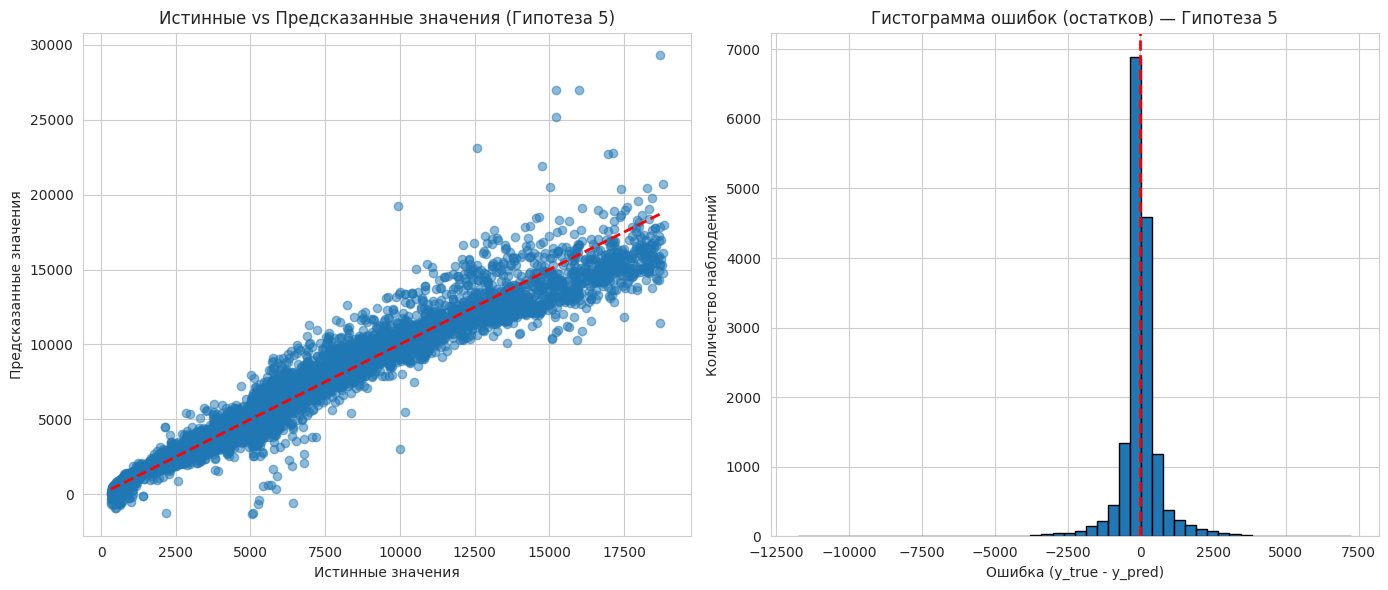

In [15]:
# Графики для Гипотезы 5
plt.figure(figsize=(14, 6))

# 1. Истинные vs Предсказанные
plt.subplot(1, 2, 1)
plt.scatter(y_test_hyp5, y_pred_hyp5, alpha=0.5)
plt.plot([y_test_hyp5.min(), y_test_hyp5.max()],
         [y_test_hyp5.min(), y_test_hyp5.max()],
         'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные значения (Гипотеза 5)')
plt.grid(True)

# 2. Гистограмма ошибок
plt.subplot(1, 2, 2)
plt.hist(residuals_hyp5, bins=50, edgecolor='black')
plt.title("Гистограмма ошибок (остатков) — Гипотеза 5")
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.grid(True)

plt.tight_layout()
plt.show()



Здесь мы видим еффект закручивания, однако он минимальный и точки расположены гораздо плотнее к линии. Ето пока что наш лучший результат. Теперь попробуем написать имплементацию линейной регрессии

## Имплементация линейной регрессии

Напишем линейную регрессию через градиентный спуск, иначе она будет практически полностью повторять результаты sklearn.LinearRegression

In [16]:

class MyLinearRegression:
    def __init__(self, lr=0.01, n_iters=3000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        for _ in range(self.n_iters):
            y_pred = X @ self.weights + self.bias

            dw = (1 / n_samples) * X.T @ (y_pred - y)
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return X @ self.weights + self.bias


# Обучение
my_lin_reg = MyLinearRegression(lr=0.01, n_iters=3000)
my_lin_reg.fit(X_train_proc, y_train)

y_pred = my_lin_reg.predict(X_test_proc)

# МЕТРИКИ
print("=" * 50)
print("Имплементированная линейная регрессия")
print("=" * 50)
print(f"R2:   {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")


Имплементированная линейная регрессия
R2:   0.9075
RMSE: 1200.9068
MAE:  804.3214


In [17]:
results_linreg.append({
    "Гипотеза": "Имплементированная линейная регрессия",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})

In [18]:
df_results = pd.DataFrame(results_linreg)

print("="*70)
print("Сравнение всех моделей Linear Regression")
print("="*70)
display(df_results.sort_values("R2", ascending=False))

Сравнение всех моделей Linear Regression


,Гипотеза,R2,RMSE,MAE
5,Гипотеза 5,0.964188,747.347049,409.979491
2,Гипотеза 2,0.932176,1028.484400,468.102047
3,Гипотеза 3,0.920209,1115.535924,734.066016
0,Базовая,0.920187,1115.690565,734.241516
1,Гипотеза 1,0.920187,1115.690565,734.241516
6,Гипотеза 2 + 5,0.908585,1194.031736,468.841783
7,Имплементированная линейная регрессия,0.908585,1194.031736,468.841783
4,Гипотеза 4,0.903787,1224.965394,900.661667


Имплементированная линейная регрессия в целом работает сопоставимо с базовой моделью, но показывает другой характер ошибок. Хотя по R2 и RMSE она немного уступает стандартной линейной регрессии, средняя абсолютная ошибка у неё заметно ниже. Это означает, что в большинстве случаев модель предсказывает цену ближе к истинной, но иногда допускает отдельные крупные промахи, которые сильнее влияют на RMSE. Таким образом, собственная реализация не хуже базовой «в целом», а скорее более стабильна для типичных объектов и менее устойчива к редким экстремальным значениям цены.

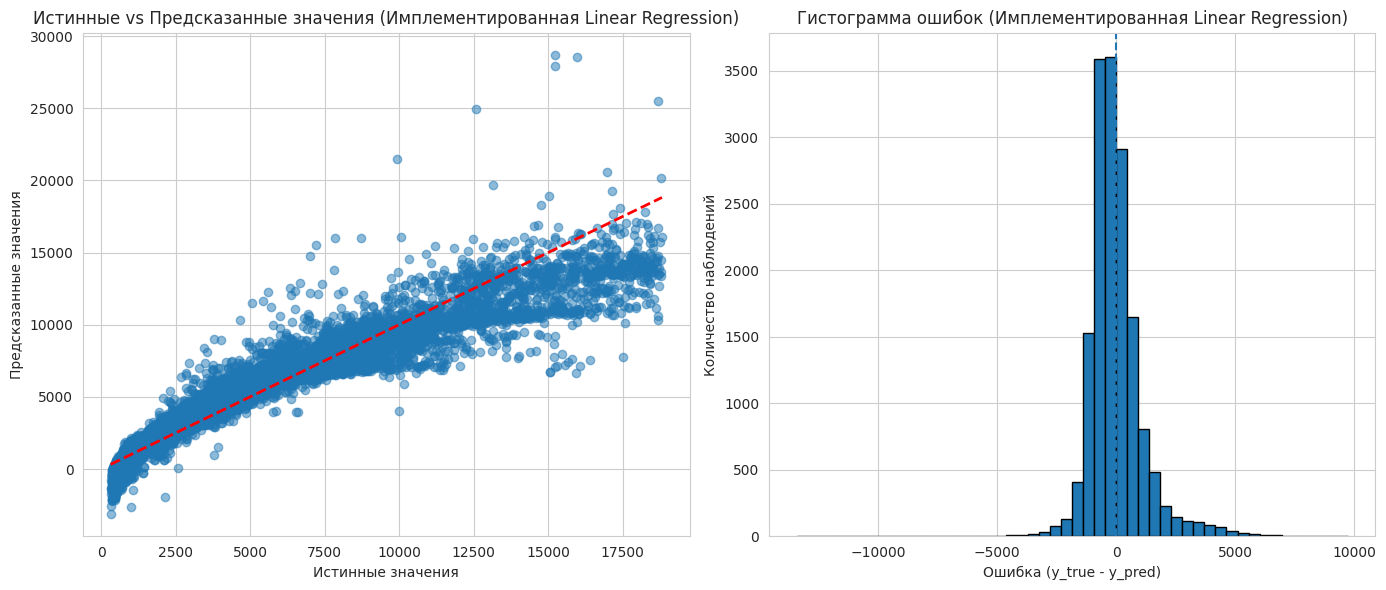

In [19]:
# Остатки
residuals = y_test - y_pred

plt.figure(figsize=(14, 6))

# 1. Истинные vs Предсказанные
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    lw=2
)
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Истинные vs Предсказанные значения (Имплементированная Linear Regression)")
plt.grid(True)

# 2. Гистограмма остатков
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.axvline(0, linestyle='--')
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.title("Гистограмма ошибок (Имплементированная Linear Regression)")
plt.grid(True)

plt.tight_layout()
plt.show()

На графике мы как раз можем заметить отдельные крупные промахи. В целом ничего особого нового на данном графике по сравнению с другими нет. Было бы странно, если было бы

#  Улучшаем собственную линейную регрессию

Попробуем улучшить собственную линейную регрессию двумя способами: сначала совместим ее с гипотезой 5, потом с 2, а потом сравним все метрики и сделаем выводы

In [20]:
class MyLinearRegression:
    def __init__(self, lr=0.01, n_iters=3000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        for _ in range(self.n_iters):
            y_pred = X @ self.weights + self.bias

            dw = (1 / n_samples) * X.T @ (y_pred - y)
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return X @ self.weights + self.bias


# Гипотеза 5
segments = [(0, 5000), (5000, np.inf)]
y_pred_seg = np.zeros(len(y_test))

for seg_min, seg_max in segments:
    mask_train = (y_train >= seg_min) & (y_train < seg_max)
    mask_test = (y_test >= seg_min) & (y_test < seg_max)

    if mask_train.sum() == 0 or mask_test.sum() == 0:
        continue

    my_lin_reg = MyLinearRegression(lr=0.01, n_iters=3000)
    my_lin_reg.fit(X_train_proc[mask_train], y_train[mask_train])

    y_pred_seg[mask_test] = my_lin_reg.predict(X_test_proc[mask_test])


# Метрики
print("=" * 60)
print("Имплементированная линейная регрессия + гипотеза 5")
print("=" * 60)
print(f"R2:   {r2_score(y_test, y_pred_seg):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_seg)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_seg):.4f}")

results_linreg.append({
    "Гипотеза": "Имплементированная LR + гипотеза 5",
    "R2": r2_score(y_test, y_pred_seg),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_seg)),
    "MAE": mean_absolute_error(y_test, y_pred_seg)
})

Имплементированная линейная регрессия + гипотеза 5
R2:   0.9515
RMSE: 869.3110
MAE:  492.0828


In [21]:
class MyLinearRegression:
    def __init__(self, lr=0.01, n_iters=3000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        for _ in range(self.n_iters):
            y_pred = X @ self.weights + self.bias

            dw = (1 / n_samples) * X.T @ (y_pred - y)
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return X @ self.weights + self.bias

# Гипотеза 2

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


my_lin_reg_log = MyLinearRegression(lr=0.01, n_iters=3000)
my_lin_reg_log.fit(X_train_proc, y_train_log)


y_pred_log = my_lin_reg_log.predict(X_test_proc)


y_pred = np.expm1(y_pred_log)


# Метрики 
print("=" * 60)
print("Имплементированная линейная регрессия + гипотеза 2 (log y)")
print("=" * 60)
print(f"R2:   {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")

results_linreg.append({
    "Гипотеза": "Имплементированная LR + гипотеза 2",
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred)
})



Имплементированная линейная регрессия + гипотеза 2 (log y)
R2:   0.1613
RMSE: 3616.6025
MAE:  707.2164


In [22]:
df_results = pd.DataFrame(results_linreg)

print("="*70)
print("Сравнение всех моделей Linear Regression")
print("="*70)
display(df_results.sort_values("R2", ascending=False))

Сравнение всех моделей Linear Regression


,Гипотеза,R2,RMSE,MAE
5,Гипотеза 5,0.964188,747.347049,409.979491
8,Имплементированная LR + гипотеза 5,0.951545,869.311038,492.082837
2,Гипотеза 2,0.932176,1028.484400,468.102047
3,Гипотеза 3,0.920209,1115.535924,734.066016
0,Базовая,0.920187,1115.690565,734.241516
1,Гипотеза 1,0.920187,1115.690565,734.241516
6,Гипотеза 2 + 5,0.908585,1194.031736,468.841783
7,Имплементированная линейная регрессия,0.908585,1194.031736,468.841783
4,Гипотеза 4,0.903787,1224.965394,900.661667
9,Имплементированная LR + гипотеза 2,0.161333,3616.602455,707.216353


Как можно заметить гипотеза 5 так же дает очень хорошую прибавку в моей линейной регрессии, однако результаты хуже чем у оригинальной. Ето связано с ее особенностью реализации, а именно с градиентным бустингом. Градиентный бустинг просто не успевает сойтись. Что же касается имплементированного LR + гипотезы 2, то мы можем наблюдать настоящую трагедию. В отличие от аналитического решения в sklearn, градиентный спуск чувствителен к масштабу признаков и целевой переменной, а также к выбору шага обучения. В лог-пространстве текущие параметры обучения приводят к плохой сходимости модели, из-за чего она не способна адекватно аппроксимировать зависимость. Ну а наилучшие результаты уже вторую лабораторную показывает максимально простая гипотеза с разделением цены на меньше пяти тысяч и больше пяти тысяч. Я думаю подобная тенденция будет продолжаться и дальше и возможно можно будет вообще отказаться от проверки других гипотез, данная все равно всегда будет давать наибольший прирост, а с другими гипотезами она плохо сочетается, как мы могли заметить уже дважды.

# Логистическая регрессия
## Создание бейзлайна логической регрессии и оценка качества

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

df = pd.read_csv("adult.csv")  # замените путь на локальный файл

# Удаляем строки с '?'
original_rows = len(df)
df = df[~df.applymap(lambda x: str(x).strip() == '?').any(axis=1)]
print(f"Было строк: {original_rows}")
print(f"Стало строк: {len(df)}")
print(f"Удалено строк: {original_rows - len(df)}")

Было строк: 32561
Стало строк: 30162
Удалено строк: 2399


In [24]:
# Целевая переменная
y = df['salary'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
X = df.drop('salary', axis=1)

# Разделение признаков на числовые и категориальные
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Препроцессинг
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [25]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Логистическая регрессия 
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=500, class_weight='balanced'))
])

# Обучение модели
logreg_pipeline.fit(X_train, y_train)

# Предсказания
y_pred = logreg_pipeline.predict(X_test)
y_prob = logreg_pipeline.predict_proba(X_test)[:, 1]

In [26]:
# Метрики
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

results_logreg = []

print("="*50)
print("Базовая логистическая регрессия")
print("="*50)
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")

# Сохраняем результаты для анализа
results_logreg.append({
    "Гипотеза": "Базовая",
    "F1": f1,
    "Accuracy": accuracy,
    "ROC-AUC": roc_auc
})

Базовая логистическая регрессия
F1-score: 0.6855
Accuracy: 0.8093
ROC-AUC:  0.9021


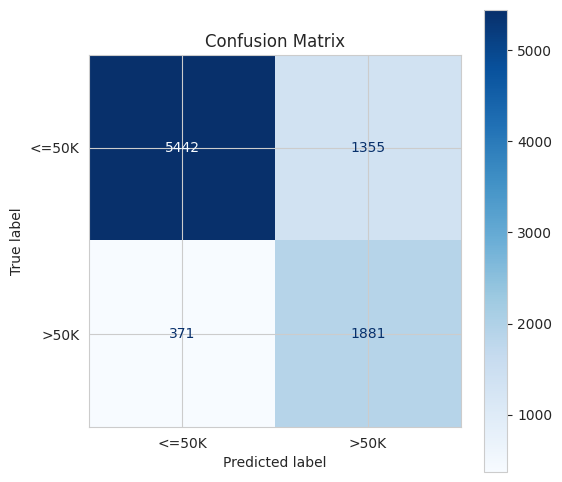

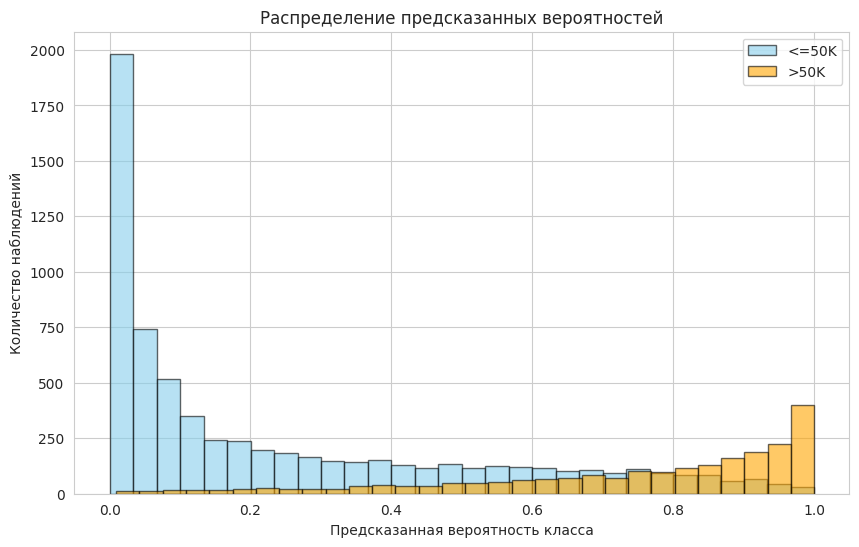

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['<=50K', '>50K'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()


# Гистограмма предсказанных вероятностей
plt.figure(figsize=(10, 6))
plt.hist(y_prob[y_test == 0], bins=30, alpha=0.6, label='<=50K', color='skyblue', edgecolor='black')
plt.hist(y_prob[y_test == 1], bins=30, alpha=0.6, label='>50K', color='orange', edgecolor='black')
plt.xlabel("Предсказанная вероятность класса")
plt.ylabel("Количество наблюдений")
plt.title("Распределение предсказанных вероятностей")
plt.legend()
plt.grid(True)
plt.show()

Результаты базовой логистической регрессии показывают, что модель справляется с задачей неплохо, хотя есть нюансы. F1-score около 0.69 говорит о том, что мы снова сталкиваеся с проблемой, когда один из классов хуже определяется, хотя данный показатель уже выше, чем при самом улучшенном KNN. Accuracy выше 0.80 - неплохой результат, но очевидно есть куда стремиться. . ROC-AUC почти 0.90 вселяет надежду, что возможно изменив немного порог, сдвинув его с 0.5 на другое число, качество предскааний модели повысится.

# Выдвигаем гипотезы

## Гипотеза 1 - улучшение препроцессинга признаков
Стандартизация числовых признаков и корректная кодировка категориальных через OneHotEncoder или Target Encoding уменьшает разброс и делает обучение модели стабильнее.

## Гипотеза 2 - подбор гиперпараметров регуляризации
Настройка коэффициента регуляризации (C для L1 или L2) и solver через кросс-валидацию снижает переобучение и повышает точность предсказаний.

## Гипотеза 3 - балансировка классов
Использование class_weight='balanced' компенсирует несбалансированные классы и повышает F1-score для редкого класса.

## Гипотеза 4 - сдвиг порога классификации
Изменение порога вероятности (по умолчанию 0.5) для перевода вероятности в метку класса позволяет оптимизировать F1-score или другие метрики для конкретного класса.

## Гипотеза 5 - удаление малоинформативных признаков
Исключение признаков с низкой информативностью снижает шум и делает модель стабильнее.

In [28]:
# Гипотеза 1 
# Препроцессинг
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=500))
])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:,1]

results_logreg.append({
    "Гипотеза": "Гипотеза 1",
    "F1": f1_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba)
})

In [29]:
# Гипотеза 2
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

grid_logreg = GridSearchCV(logreg, param_grid, scoring='f1', cv=5)
grid_logreg.fit(X_train, y_train)

y_pred = grid_logreg.predict(X_test)
y_proba = grid_logreg.predict_proba(X_test)[:,1]

best_C = grid_logreg.best_params_['clf__C']

results_logreg.append({
    "Гипотеза": "Гипотеза 2",
    "F1": f1_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba)
})

print(f"Лучший параметр C: {best_C}")

Лучший параметр C: 1


In [30]:
# Гипотеза 3
logreg_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

logreg_balanced.fit(X_train, y_train)
y_pred = logreg_balanced.predict(X_test)
y_proba = logreg_balanced.predict_proba(X_test)[:,1]

results_logreg.append({
    "Гипотеза": "Гипотеза 3 ",
    "F1": f1_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba)
})

In [31]:
# Гипотеза 4
logreg.fit(X_train, y_train)
y_proba = logreg.predict_proba(X_test)[:,1]

best_f1 = 0
best_threshold = 0.5
y_pred_best = None

# Перебираем пороги от 0.1 до 0.9 с шагом 0.01
for threshold in np.arange(0.1, 0.91, 0.01):
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        y_pred_best = y_pred_thresh

results_logreg.append({
    "Гипотеза": "Гипотеза 4",
    "F1": best_f1,
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "ROC-AUC": roc_auc_score(y_test, y_proba)
})

print(f"Лучший порог для F1-score: {best_threshold:.2f}")

Лучший порог для F1-score: 0.32


In [32]:
# Гипотеза 5
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  
X_train_sel = selector.fit_transform(preprocessor.fit_transform(X_train))
X_test_sel = selector.transform(preprocessor.transform(X_test))

logreg_sel = LogisticRegression(max_iter=500)
logreg_sel.fit(X_train_sel, y_train)
y_pred = logreg_sel.predict(X_test_sel)
y_proba = logreg_sel.predict_proba(X_test_sel)[:,1]

results_logreg.append({
    "Гипотеза": "Гипотеза 5 ",
    "F1": f1_score(y_test, y_pred),
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba)
})


Сравнение всех моделей логистической регрессии (по F1-score)


,Гипотеза,F1,Accuracy,ROC-AUC
0,Гипотеза 4,0.691466,0.828600,0.902339
1,Базовая,0.685496,0.809261,0.902138
2,Гипотеза 3,0.685496,0.809261,0.902138
3,Гипотеза 1,0.662136,0.846171,0.902339
4,Гипотеза 2,0.662136,0.846171,0.902339
5,Гипотеза 5,0.659844,0.845729,0.901953


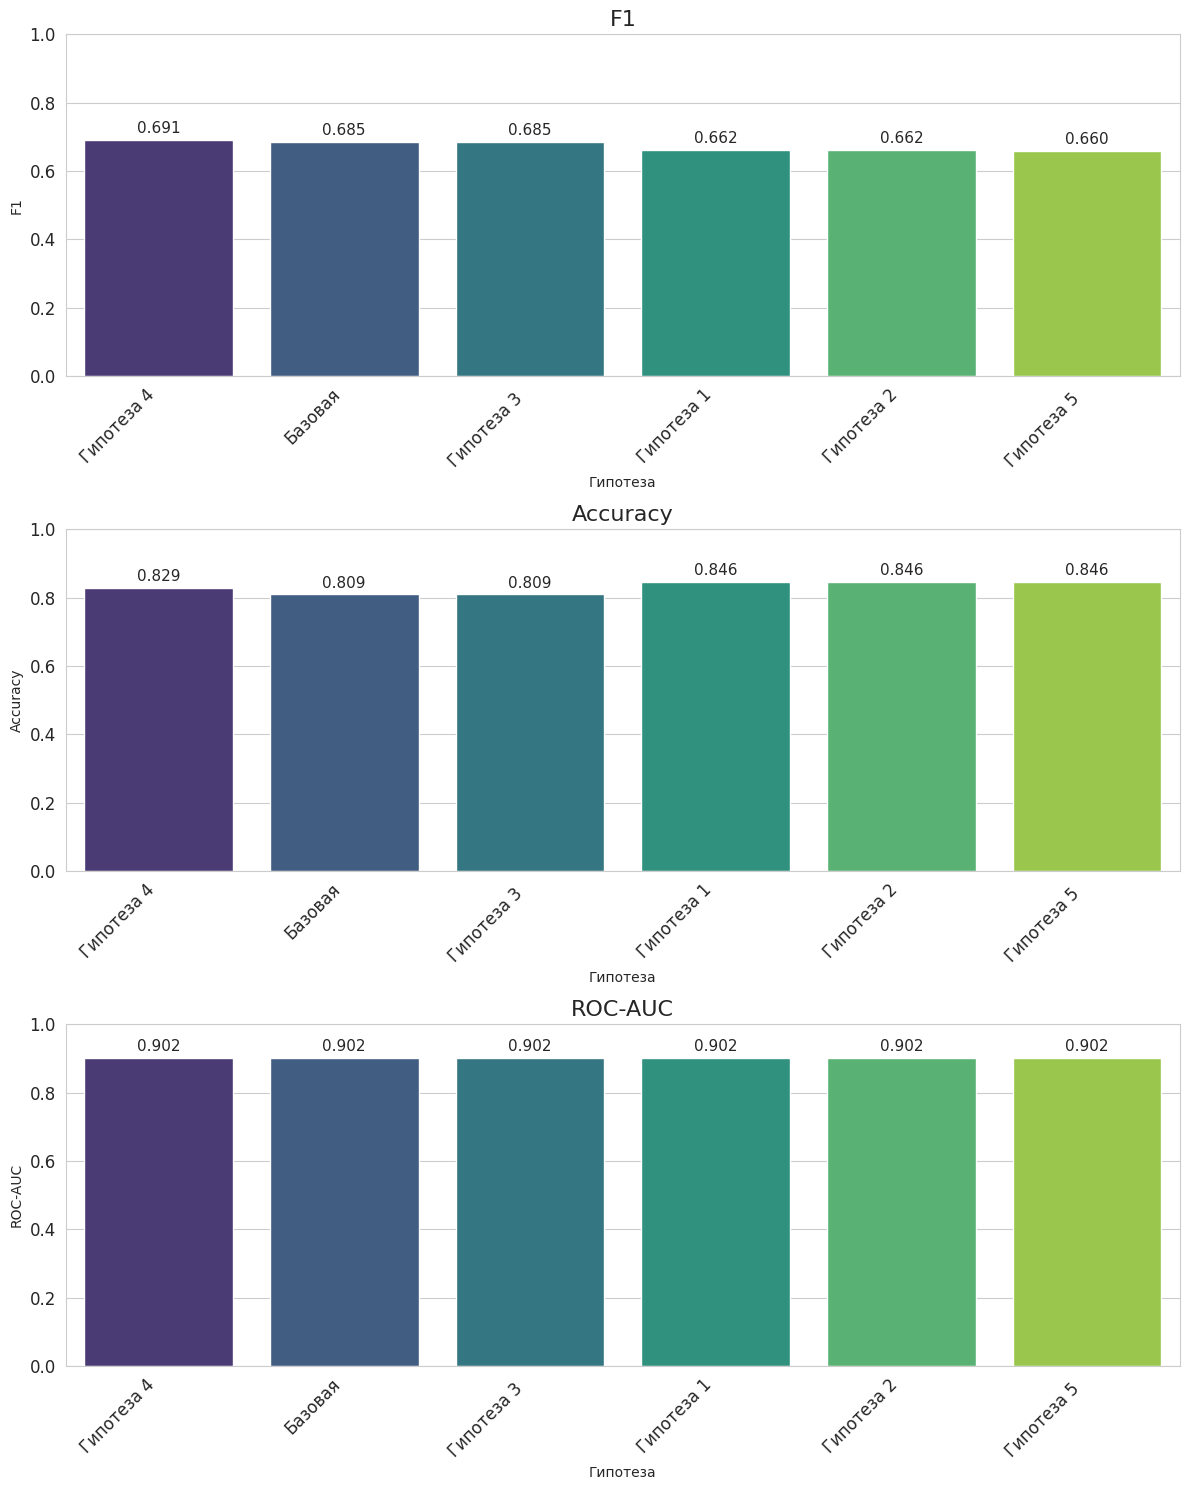

In [33]:
df_results = pd.DataFrame(results_logreg)

# Сортировка по F1-score
df_results = df_results.sort_values(by="F1", ascending=False).reset_index(drop=True)

# Вывод таблицы
print("="*70)
print("Сравнение всех моделей логистической регрессии (по F1-score)")
print("="*70)
display(df_results)  

metrics = ["F1", "Accuracy", "ROC-AUC"]
plt.figure(figsize=(12, len(metrics) * 5))  

for i, metric in enumerate(metrics, 1):
    plt.subplot(len(metrics), 1, i)
    sns.barplot(x="Гипотеза", y=metric, data=df_results, palette="viridis")
    plt.title(metric, fontsize=16)
    plt.ylim(0, 1)  # для нормализации шкалы
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    for index, value in enumerate(df_results[metric]):
        plt.text(index, value + 0.02, f"{value:.3f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

Гипотеза 4 явно выделяется — она дала лучший F1-score (0.691) и при этом неплохо держит Accuracy. Это говорит о том, что сдвиг порога классификации действительно улучшает способность модели правильно определять редкий класс (>50K), не сильно ухудшая общую точность.

Базовая модель и гипотезы 1–3 показывают схожие метрики, но F1-score у них ниже, особенно у гипотез 1 и 2.

Гипотеза 5 (сегментация) в данном случае работает хуже всех по F1, несмотря на хорошую Accuracy. Вероятно, из-за того, что распределение классов внутри сегментов неравномерное, и модель теряет способность корректно распознавать редкий класс.

В целом, как и в случае с KNN, ничего особо не меняется и мы боремся лишь за крохи улучшений. Но попробуем все же собрать улучшенный бейзлайн из нескольких гипотез.

# Улучшенный бейзлайн

In [34]:
y = df['salary'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
X = df.drop('salary', axis=1)

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Препроцессинг
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Улучшенный пайплайн ---
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=500, solver='liblinear', penalty='l2'))
])

# Обучаем модель
logreg_pipeline.fit(X_train, y_train)

# Предсказанные вероятности
y_proba = logreg_pipeline.predict_proba(X_test)[:,1]

# Подбор порога по F1
thresholds = np.arange(0.1, 0.91, 0.01)
best_f1 = 0
best_threshold = 0.5
best_pred = None

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
        best_pred = y_pred_t

# Метрики с оптимальным порогом
accuracy = accuracy_score(y_test, best_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("="*50)
print("Улучшенный бейзлайн (Logistic Regression)")
print("="*50)
print(f"Оптимальный порог: {best_threshold:.2f}")
print(f"F1-score: {best_f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")

# Сохраняем результаты для анализа
results_logreg.append({
    "Гипотеза": "Улучшенный бейзлайн",
    "F1": best_f1,
    "Accuracy": accuracy,
    "ROC-AUC": roc_auc
})

Улучшенный бейзлайн (Logistic Regression)
Оптимальный порог: 0.32
F1-score: 0.6912
Accuracy: 0.8285
ROC-AUC:  0.9024


Результаты буквально на сотные хуже чем в случае с просто сдвигом порога. Так что не вижу смысла строить графики и сравнивать все с другими результами. Думаю еще сильнее улучшить у нас модель не получится. Теперь пробуем написать свою. 

# Имплементация логистической регрессии

In [35]:
# Преобразуем данные через preprocessor
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Собственная логистическая регрессия 
class MyLogisticRegression:
    def __init__(self, lr=0.1, n_iters=5000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        y = y.reshape(-1)  # убедимся, что y одномерный

        for _ in range(self.n_iters):
            linear_model = X @ self.weights + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / n_samples) * (X.T @ (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = X @ self.weights + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Обучение
my_logreg = MyLogisticRegression(lr=0.1, n_iters=5000)
my_logreg.fit(X_train_proc, y_train.values)

# Предсказания
y_pred = my_logreg.predict(X_test_proc)
y_proba = my_logreg.predict_proba(X_test_proc)

# Метрики
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("="*50)
print("Имплементированная логистическая регрессия")
print("="*50)
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")

#Сохраняем результаты
results_logreg.append({
    "Гипотеза": "Имплементированная",
    "F1": f1,
    "Accuracy": accuracy,
    "ROC-AUC": roc_auc
})

Имплементированная логистическая регрессия
F1-score: 0.6600
Accuracy: 0.8466
ROC-AUC:  0.9023


In [36]:
df_results = pd.DataFrame(results_logreg)

# Сортировка по F1-score
df_results = df_results.sort_values(by="F1", ascending=False).reset_index(drop=True)

# Вывод таблицы
print("="*70)
print("Сравнение всех моделей логистической регрессии (по F1-score)")
print("="*70)
display(df_results)  

Сравнение всех моделей логистической регрессии (по F1-score)


,Гипотеза,F1,Accuracy,ROC-AUC
0,Гипотеза 4,0.691466,0.828600,0.902339
1,Улучшенный бейзлайн,0.691206,0.828489,0.902362
2,Базовая,0.685496,0.809261,0.902138
3,Гипотеза 3,0.685496,0.809261,0.902138
4,Гипотеза 1,0.662136,0.846171,0.902339
5,Гипотеза 2,0.662136,0.846171,0.902339
6,Имплементированная,0.659971,0.846613,0.902270
7,Гипотеза 5,0.659844,0.845729,0.901953


Ничего интересного. Получили небольшую пибавку в точности за счет жертвы в F1. Думаю единственная гипотезы, которую имеет смысл применять - гипотеза 4. Остальные просто не дадут никакого улучшения. 

In [37]:
# Преобразуем данные через preprocessor
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Собственная логистическая регрессия 
class MyLogisticRegression:
    def __init__(self, lr=0.1, n_iters=5000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        y = y.reshape(-1)  

        for _ in range(self.n_iters):
            linear_model = X @ self.weights + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / n_samples) * (X.T @ (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = X @ self.weights + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Обучение
my_logreg = MyLogisticRegression(lr=0.1, n_iters=5000)
my_logreg.fit(X_train_proc, y_train.values)

# Базовые предсказания
y_pred = my_logreg.predict(X_test_proc)
y_proba = my_logreg.predict_proba(X_test_proc)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Подбор оптимального порога
thresholds = np.arange(0.1, 0.91, 0.01)
best_f1 = 0
best_threshold = 0.5

for t in thresholds:
    y_pred_thresh = my_logreg.predict(X_test_proc, threshold=t)
    f1_curr = f1_score(y_test, y_pred_thresh)
    if f1_curr > best_f1:
        best_f1 = f1_curr
        best_threshold = t

y_pred_best = my_logreg.predict(X_test_proc, threshold=best_threshold)
y_proba_best = my_logreg.predict_proba(X_test_proc)

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)

print("="*50)
print("Имплементированная + Гипотеза 4")
print("="*50)
print(f"Оптимальный порог: {best_threshold:.2f}")
print(f"F1-score: {best_f1:.4f}")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"ROC-AUC:  {roc_auc_best:.4f}")

# Сохраняем результаты 
results_logreg.append({
    "Гипотеза": "Имплементированная + Гипотеза 4",
    "F1": best_f1,
    "Accuracy": accuracy_best,
    "ROC-AUC": roc_auc_best
})


Имплементированная + Гипотеза 4
Оптимальный порог: 0.32
F1-score: 0.6896
Accuracy: 0.8283
ROC-AUC:  0.9023


In [38]:
df_results = pd.DataFrame(results_logreg)

# Сортировка по F1-score
df_results = df_results.sort_values(by="F1", ascending=False).reset_index(drop=True)

# Вывод таблицы
print("="*70)
print("Сравнение всех моделей логистической регрессии (по F1-score)")
print("="*70)
display(df_results)  

Сравнение всех моделей логистической регрессии (по F1-score)


,Гипотеза,F1,Accuracy,ROC-AUC
0,Гипотеза 4,0.691466,0.828600,0.902339
1,Улучшенный бейзлайн,0.691206,0.828489,0.902362
2,Имплементированная + Гипотеза 4,0.689573,0.828268,0.902270
3,Базовая,0.685496,0.809261,0.902138
4,Гипотеза 3,0.685496,0.809261,0.902138
5,Гипотеза 1,0.662136,0.846171,0.902339
6,Гипотеза 2,0.662136,0.846171,0.902339
7,Имплементированная,0.659971,0.846613,0.902270
8,Гипотеза 5,0.659844,0.845729,0.901953


Мы снова не наблюдаем ничего интересно. Имплементированная логистическая регрессия + Гипотеза 4 показывает результат чуть хуже, чем обычная с гипотезой 4. Ни одна гипотеза, написание собственной модели не дает практически никаких реальных улучшений. Мы получили 0,005 в F1 и + 0,02 к точности по сравнению с базовой. И все благодаря простому сдвигу порога. Никакие другие мои идеи улучшений вообще не давали, а скорее ухудшали ситуацию. Больше сказать в выодах нечего. Можно сказать что ето было топтание на месте.